### Import Modules

In [21]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from newspaper import Config, Article
from bs4 import BeautifulSoup
import requests

### Input Preprocessing functions

i) Fetches data by reading a file

In [22]:
def read_data(filename):
    sentences = []

    # Open the file in read mode
    with open(filename, 'r') as file:
        # Read each line in the file
        for line in file:
            # Strip leading/trailing whitespaces
            line = line.strip()
            # If the line is not empty, split it into sentences and add them to the list
            if line:
                # Split the line into sentences based on common delimiters like '.', '!', '?'
                line_sentences = [s.strip() for s in line.split('.') if s.strip()]
                # Extend the list of sentences
                sentences.extend(line_sentences)

    return sentences

ii) Fetches data from NEWS websites through scraping

In [4]:
def newsFetch():
    # Define the newsFetch function
    def fetch_latest_news_titles(url, printed_titles):
        # Set up configuration for the newspaper library
        config = Config()
        config.fetch_images = False
        config.memoize_articles = False

        # Fetch the HTML content of the website
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract links to individual articles
        article_links = []
        for link in soup.find_all('a', href=True):
            href = link['href']
            if href.startswith('http'):
                article_links.append(href)

        # Fetch and convert the titles of the latest news articles into the specified format
        formatted_titles = []
        for article_link in article_links:
            try:
                article = Article(article_link, config=config)
                article.download()
                article.parse()
                # Check if the title has more than 3 words and is not already printed
                title_words = article.title.split()
                if len(title_words) > 3 and article.title not in printed_titles:
                    formatted_titles.append(article.title)
                    printed_titles.add(article.title)  # Add the title to printed_titles set
            except Exception as e:
                print(f"Error fetching news from {article_link}: {e}\n")

        return formatted_titles

    # List of financial news websites
    financial_news_sites = [
        "https://www.cnbc.com/finance/"
        # Add more financial news websites here as needed
    ]

    printed_titles = set()  # Set to store printed titles

    # Fetch and print the titles of the latest news from each website
    data = []
    for site in financial_news_sites:
        data.extend(fetch_latest_news_titles(site, printed_titles))

    # Return the final list of formatted titles
    return data

### Input Data
User Option to either scrape CNBC website or give manual data.

In [23]:
sentences=newsFetch()

Error fetching news from https://www.twitter.com/cnbci?lang=en/: Article `download()` failed with 400 Client Error: Bad Request for url: https://twitter.com/cnbci?lang=en/ on URL https://www.twitter.com/cnbci?lang=en/

Error fetching news from https://help.cnbc.com/: Article `download()` failed with 403 Client Error: Forbidden for url: https://cnbc.zendesk.com/hc/en-us/ on URL https://help.cnbc.com/

Error fetching news from https://help.cnbc.com/contact/: Article `download()` failed with 403 Client Error: Forbidden for url: https://cnbc.zendesk.com/hc/en-us/requests/new?ticket_form_id=360000260093 on URL https://help.cnbc.com/contact/



In [37]:
filename = 'data.txt'
sentences = read_data(filename)

### Viewing Sentences Fetched

In [38]:
sentences

['Stocks of Yes Bank are on the rise',
 'It is expected to perform well this quarter',
 'Google stocks dipped down slighly',
 'It is expected to improve later',
 'I was quite surprising',
 'Yes Bank stocks jumped up by 25%',
 'I was quite disappointing a bit',
 'The sudden down trend of Google stocks',
 'my name is albin johns',
 'Yes Bank is on rise by 36%',
 'Tesla Inc ceo says Doge Coin is the future',
 'Tesla Inc stock price about to soar',
 'Apple Inc stocks had a sudden dip',
 'Apple Inc on a downtrend',
 'Zerodha is projected to rise',
 'Audi is expected a sudden downtrend',
 'Bloomberg Inc had a stock increase']

### Making the Model

In [25]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

In [11]:
def extract_organization_examples(examples):
    organization_examples_dict = {}

    for example in examples:
        ner_results = nlp(example)
        organization_name = ""
        for result in ner_results:
            if result['entity'] == 'B-ORG':
                organization_name += result['word']
            elif result['entity'] == 'I-ORG':
                organization_name += result['word'].replace("##", "")

        if organization_name:
            if organization_name not in organization_examples_dict:
                organization_examples_dict[organization_name] = [example]
            else:
                organization_examples_dict[organization_name].append(example)

    return organization_examples_dict


In [39]:
organization_examples = extract_organization_examples(sentences)
print(organization_examples)

{'YesBank': ['Stocks of Yes Bank are on the rise', 'Yes Bank stocks jumped up by 25%', 'Yes Bank is on rise by 36%'], 'Google': ['Google stocks dipped down slighly', 'The sudden down trend of Google stocks'], 'TeslaInc': ['Tesla Inc ceo says Doge Coin is the future', 'Tesla Inc stock price about to soar'], 'AppleInc': ['Apple Inc stocks had a sudden dip', 'Apple Inc on a downtrend'], 'Zerodha': ['Zerodha is projected to rise'], 'Audi': ['Audi is expected a sudden downtrend'], 'BloombergInc': ['Bloomberg Inc had a stock increase']}


In [30]:
tokenizer = AutoTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
model = AutoModelForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

In [31]:
def get_max_indices(sentences_dict, model, tokenizer):
    max_indices = {}
    for key, sentences in sentences_dict.items():
        scores_list = []
        for sentence in sentences:
            encoded_text = tokenizer(sentence, return_tensors='pt')
            output = model(**encoded_text)
            scores = output[0][0].detach().numpy()
            scores = softmax(scores)
            scores_list.append(np.argmax(scores))
        max_indices[key] = scores_list
    return max_indices

In [40]:
data = get_max_indices(organization_examples, model, tokenizer)
data

{'YesBank': [1, 2, 2],
 'Google': [0, 0],
 'TeslaInc': [1, 2],
 'AppleInc': [0, 1],
 'Zerodha': [2],
 'Audi': [0],
 'BloombergInc': [2]}

negative sentiment = 0
neutral sentiment = 1 
positive sentiment = 2

In [41]:
sentiment_scores = {}

for company, sentiments in data.items():
    score = 0
    for sentiment in sentiments:
        if sentiment == 2:
            score += 1
        elif sentiment == 0:
            score -= 1
    sentiment_scores[company] = score

# Extracting x and y data for plotting
companies = list(sentiment_scores.keys())
scores = list(sentiment_scores.values())

### Visualization Dashboard

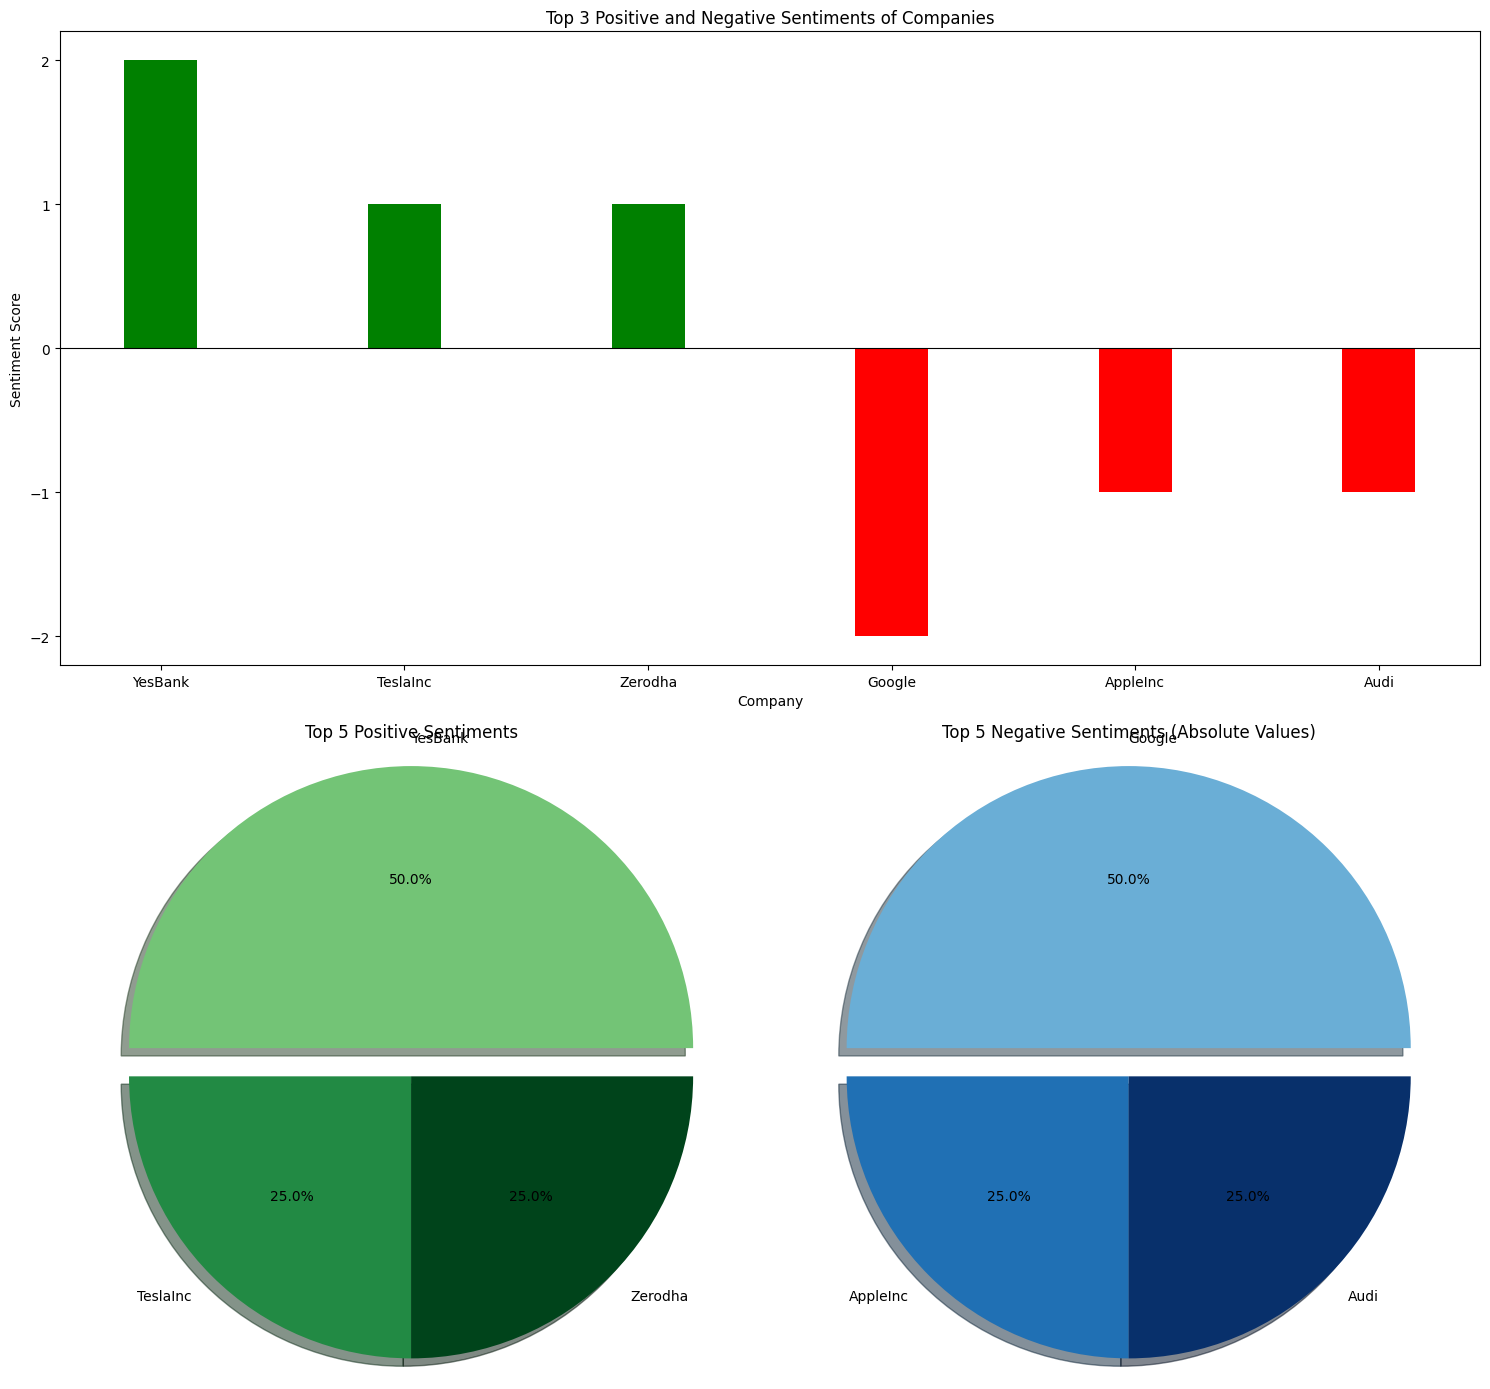

In [43]:
positive_sentiments = {company: score for company, score in sentiment_scores.items() if score > 0}
negative_sentiments = {company: abs(score) for company, score in sentiment_scores.items() if score < 0}

# Sorting the sentiment scores
sorted_positive_sentiments = dict(sorted(positive_sentiments.items(), key=lambda item: item[1], reverse=True)[:3])
sorted_negative_sentiments = dict(sorted(negative_sentiments.items(), key=lambda item: abs(item[1]), reverse=True)[:3])

# Plotting the bar chart
plt.figure(figsize=(15, 14))

plt.subplot(2, 1, 1)
plt.bar(sorted_positive_sentiments.keys(), sorted_positive_sentiments.values(), color='green', width=0.3)
plt.bar(sorted_negative_sentiments.keys(), [-score for score in sorted_negative_sentiments.values()], color='red', width=0.3)  # Invert y-coordinate
plt.xlabel('Company')
plt.ylabel('Sentiment Score')
plt.title('Top 3 Positive and Negative Sentiments of Companies')
plt.axhline(color='black', linewidth=0.8)  # Adding a horizontal line at y=0

# Set y-axis ticks and labels to negative values for negative sentiment
plt.yticks(np.arange(-max(sorted_negative_sentiments.values()), max(sorted_positive_sentiments.values())+1, 1))

# Colors for positive sentiment pie chart
if sorted_positive_sentiments:
    positive_colors = cm.Greens(np.linspace(0.5, 1, len(sorted_positive_sentiments)))
else:
    positive_colors = None

# Pie chart for positive sentiments
plt.subplot(2, 2, 3)
if sorted_positive_sentiments:
    explode_pos = [0.1 if i == 0 else 0 for i in range(len(sorted_positive_sentiments))]
    plt.pie(sorted_positive_sentiments.values(), labels=sorted_positive_sentiments.keys(), autopct='%1.1f%%', explode=explode_pos, colors=positive_colors, shadow=True)
    plt.title('Top 5 Positive Sentiments')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
else:
    plt.text(0.5, 0.5, 'No positive sentiments', horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off')  # Turn off axis

# Colors for negative sentiment pie chart
if sorted_negative_sentiments:
    negative_colors = cm.Blues(np.linspace(0.5, 1, len(sorted_negative_sentiments)))
else:
    negative_colors = None

# Pie chart for negative sentiments
plt.subplot(2, 2, 4)
if sorted_negative_sentiments:
    explode_neg = [0.1 if i == 0 else 0 for i in range(len(sorted_negative_sentiments))]
    plt.pie(sorted_negative_sentiments.values(), labels=sorted_negative_sentiments.keys(), autopct='%1.1f%%', explode=explode_neg, colors=negative_colors, shadow=True)
    plt.title('Top 5 Negative Sentiments (Absolute Values)')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
else:
    plt.text(0.5, 0.5, 'No negative sentiments', horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()